In [2]:
%matplotlib inline

import datacube
from datacube.storage import masking

dc = datacube.Datacube(app='test_animation')

In [21]:
#illegal mining, forest clearing 
#Ankobra River, Ghana
area_name ='ankobra_river'
query = {'lat': (5.09, 5.14), 'lon':(-2.265,-2.215),
        'output_crs': 'EPSG:32630',
        'resolution': (-30,30),
        }
rgb_bands = ['red','green','blue']
band_index = 'mndwi'
clear_frac = 0.8
band_index_cmap = 'brg_r'
band_index_min, band_index_max = -0.6, 0.5
sensors = [5,7,8]
mask_cloud = False
percentile_stretch = (0.01, 0.98)
resample = '1Y'

# Freetown
query = {'lat': (8.33, 8.51), 'lon':(-13.31, -13.13),
        'output_crs': 'EPSG:32628',
        'resolution': (-30,30),
        }
band_index=None
clear_frac=0.9
sensors = [7]

In [22]:
import xarray as xr
from skimage.morphology import disk, binary_dilation

bad = ['LC08_L1TP_205049_20161126_20170317_01_T1', 'LC08_L1TP_168061_20140627_20170421_01_T1',
       'LC08_L1TP_195056_20130621_20170504_01_T1','LC08_L1TP_195056_20141201_20170417_01_T1',
       'LC08_L1TP_195056_20161120_20170318_01_T1','LC08_L1TP_173062_20161126_20170317_01_T1',
       'LC08_L1TP_173062_20170724_20170809_01_T1']

bad = []

def load_and_combine(query, base_bands =['red','green','blue'], band_index = None, mask_cloud=True,
                     dilation=0, clear_frac=0.8, sensors=[5,7,8]):
    bands = base_bands.copy()
    if not band_index is None:
        if band_index.lower() == 'mndwi':
            if not 'green' in bands: bands += ['green']
            if not 'swir1' in bands: bands += ['swir1']
        if band_index.lower() == 'ndbi':
            if not 'nir' in bands: bands += ['nir']
            if not 'swir1' in bands: bands += ['swir1']
        if band_index.lower() == 'ndvi':
            if not 'nir' in bands: bands += ['nir']
            if not 'red' in bands: bands += ['red']
    
    datasets =[]
    for sensor in sensors:
        product = 'ls%d_usgs_sr_scene'%sensor
        
        dss = dc.find_datasets(
            product=product, measurements=bands,**query)
        #print("Found %d datasets for Landsat %d."%(len(dss), sensor))
        for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
        print("Found %d good datasets for Landsat %d."%(len(dss), sensor))
        if len(dss)==0:continue

        if len(dss)>100 and (not 'time' in query):
            ds_set =[]
            for time_slice in [('1980-01-01','1999-12-31'), ('2000-01-01','2004-12-31'), ('2005-01-01','2009-12-31'),
                               ('2010-01-01','2014-12-31'), ('2015-01-01','2020-01-01')]:
                sub_query = query.copy()
                sub_query['time'] = time_slice
                dss = dc.find_datasets(product=product, measurements=bands,**sub_query)
                for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
                print("Found %d good datasets for Landsat %d for %s to %s."%(len(dss), sensor, time_slice[0],time_slice[1]))
                if len(dss)==0:continue
                ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**sub_query)
                pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**sub_query)
                mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
                #if 'blue' in ds: mask = mask & (ds.blue<1000)
                if dilation >0:
                    mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
                good = mask.groupby('time').mean() >= clear_frac
                if good.sum()==0: continue
                ds_clean = ds.isel(time=good)
                if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
                ds_clean = ds_clean.where(ds_clean>0,) 
                ds_clean['mask'] = mask.isel(time=good)
                ds_set.append(ds_clean)
                print("Found %d clear observations for Landsat %d."%(len(ds_clean.time), sensor))
               
            ds_clean = xr.concat(ds_set, dim='time')
            
        else:
            ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**query)
            pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**query)
            mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
            #if 'blue' in ds: mask = mask & (ds.blue<1000)
            if dilation >0:
                mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
            good = mask.groupby('time').mean() >= clear_frac
            if good.sum()==0: continue
            ds_clean = ds.isel(time=good)
            if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
            ds_clean = ds_clean.where(ds_clean>0,) 
            ds_clean['mask'] = mask.isel(time=good)
            print("Found %d clear observations for Landsat %d."%(len(ds_clean.time), sensor))
        
        if not band_index is None:
            if band_index.lower() == 'mndwi': 
                ds_clean[band_index] = (ds_clean.green-ds_clean.swir1)/(ds_clean.green+ds_clean.swir1)
            if band_index.lower() == 'ndbi':
                ds_clean[band_index] = (ds_clean.swir1-ds_clean.nir)/(ds_clean.swir1+ds_clean.nir)
            if band_index.lower() == 'ndvi':
                ds_clean[band_index] = (ds_clean.nir-ds_clean.red)/(ds_clean.nir+ds_clean.red)
        #ds_clean[band_index] = ds_clean[band_index].where(ds_clean.mask)
        datasets.append(ds_clean)
    
    if len(datasets)>0:
        combined_ds = xr.concat(datasets, dim='time')
        combined_ds = combined_ds.sortby('time')
        return combined_ds
    else: return None
    

In [23]:
ds = load_and_combine(query, base_bands = rgb_bands, band_index = band_index, clear_frac=clear_frac, 
                      mask_cloud=mask_cloud, sensors=sensors)

Found 184 good datasets for Landsat 7.
Found 0 good datasets for Landsat 7 for 1980-01-01 to 1999-12-31.
Found 51 good datasets for Landsat 7 for 2000-01-01 to 2004-12-31.


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Found 8 clear observations for Landsat 7.
Found 41 good datasets for Landsat 7 for 2005-01-01 to 2009-12-31.


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Found 1 clear observations for Landsat 7.
Found 42 good datasets for Landsat 7 for 2010-01-01 to 2014-12-31.


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Found 12 clear observations for Landsat 7.
Found 50 good datasets for Landsat 7 for 2015-01-01 to 2020-01-01.


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Found 10 clear observations for Landsat 7.


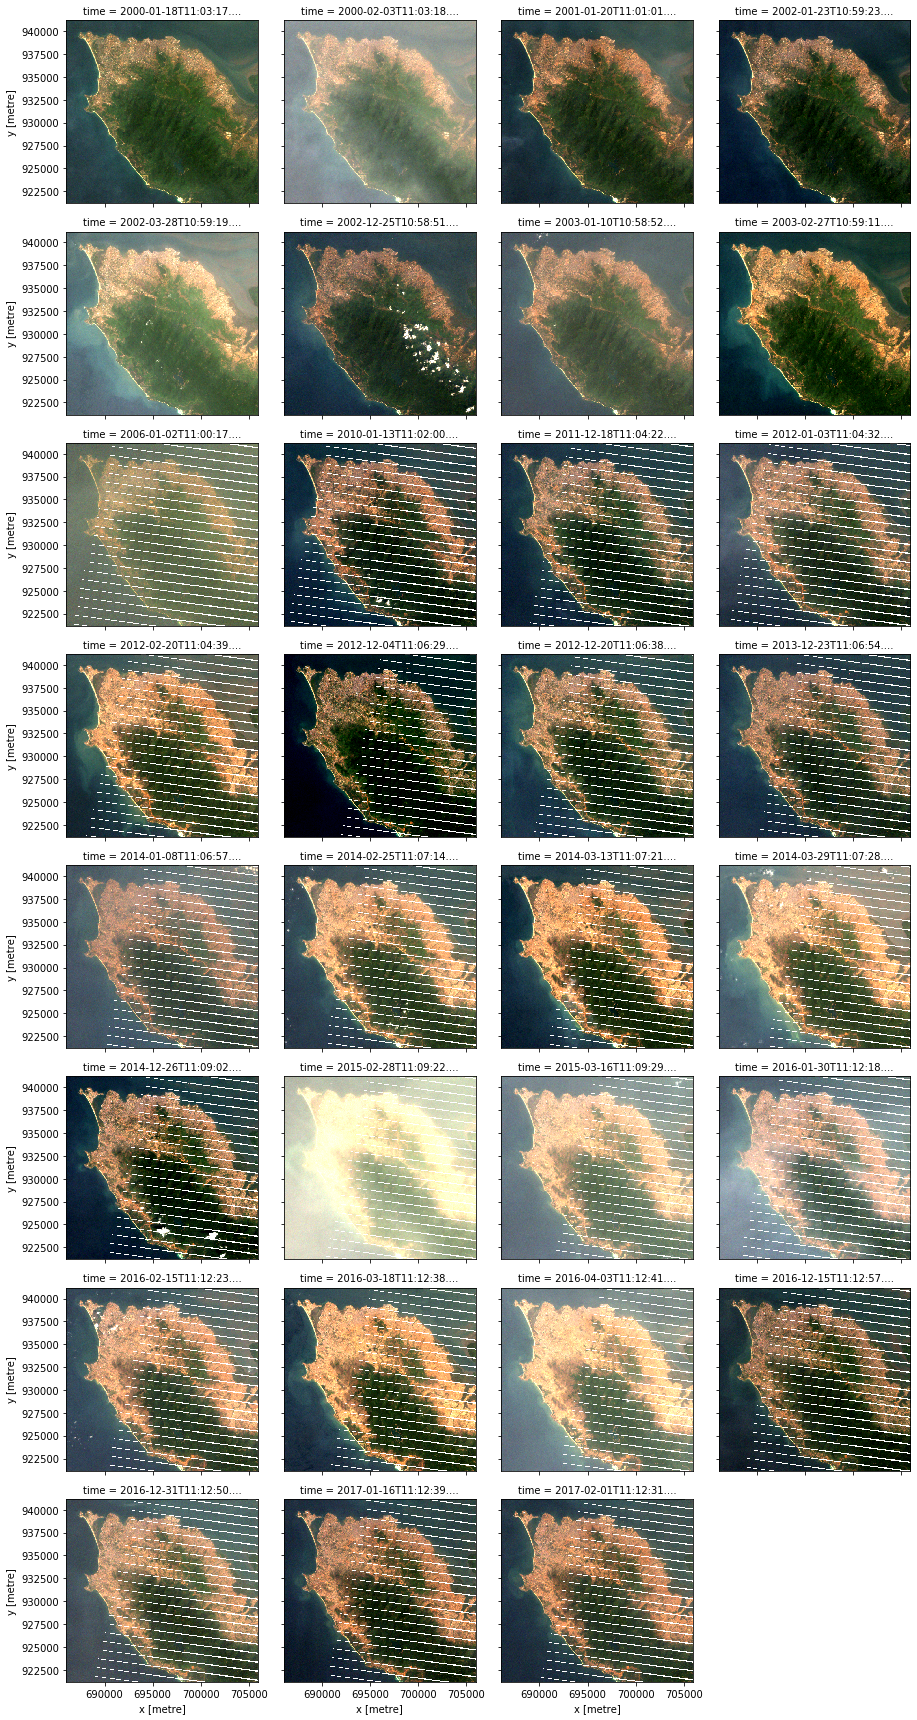

In [24]:
ds[['red', 'green', 'blue']].to_array().plot.imshow(col='time',col_wrap=4, robust=True);

In [7]:
ds

<xarray.Dataset>
Dimensions:  (time: 57, x: 665, y: 667)
Coordinates:
  * y        (y) float64 9.412e+05 9.411e+05 9.411e+05 ... 9.212e+05 9.212e+05
  * x        (x) float64 6.86e+05 6.861e+05 6.861e+05 ... 7.059e+05 7.059e+05
  * time     (time) datetime64[ns] 1986-01-03T10:38:08.345031 ... 2017-12-18T11:12:51.272023
Data variables:
    red      (time, y, x) float64 816.0 816.0 816.0 816.0 ... 575.0 632.0 603.0
    green    (time, y, x) float64 1.005e+03 1.005e+03 1.005e+03 ... 630.0 598.0
    blue     (time, y, x) float64 883.0 903.0 903.0 922.0 ... 499.0 528.0 439.0
    mask     (time, y, x) bool True True True True True ... True True True True
Attributes:
    crs:      EPSG:32628

In [8]:
ds[band_index].plot.imshow(col='time',col_wrap=4,vmin=0.1, vmax=0.6, cmap=band_index_cmap, add_colorbar=False);

KeyError: None